In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
from data_handling.Data_Reader import DataReader
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import wandb
from scipy import stats
from scipy.stats import linregress
import copy
from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Constants

In [3]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS
slopes = constants.SLOPES

Load the data and proccess it

In [4]:
def load_data(data_path, slopes=None, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    if slopes:
        chosen_data.groupby('subjects').apply(normalize_params, slopes)
    else:
        chosen_data = chosen_data.drop(columns=constants.SLOPES)
        

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

def normalize_params(data, params):
    data_copy = copy.deepcopy(data)

    for param in params:
        data_copy[param] = stats.zscore(data_copy[param], nan_policy='omit')

    return data    

In [5]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers=outliers)

print(f'num young: {young_subjects_raw.subjects.nunique()}, num old: {old_subjects_raw.subjects.nunique()}')

num young: 17, num old: 15


In [6]:
DataProcessor.outliers_counter(chosen_data_raw, params_to_work_with, chosen_rois_dict)

outliers counter: {'H023_IN': 36, 'H039_JH': 27, 'H050_AB': 20, 'H041_VG': 11, 'H019_AF': 10, 'H037_YB': 9, 'H025_SH': 7, 'H032_JD': 7, 'H033_MB': 7, 'H052_OF': 7, 'H034_HB': 6, 'H031_IN': 6, 'H026_LY': 5, 'H022_YR': 5, 'H044_AZ': 4, 'H051_YK': 4, 'H028_LC': 3, 'H030_NS': 3, 'H035_DN': 3, 'H061_SE': 2, 'H021_DH': 2, 'H018_AS': 2, 'H020_RR': 2, 'H038_GB': 2, 'H043_OS': 1, 'H055_MY': 1, 'H045_PO': 1, 'H048_GA': 1, 'H040_RK': 1}


## Raw data analysis 

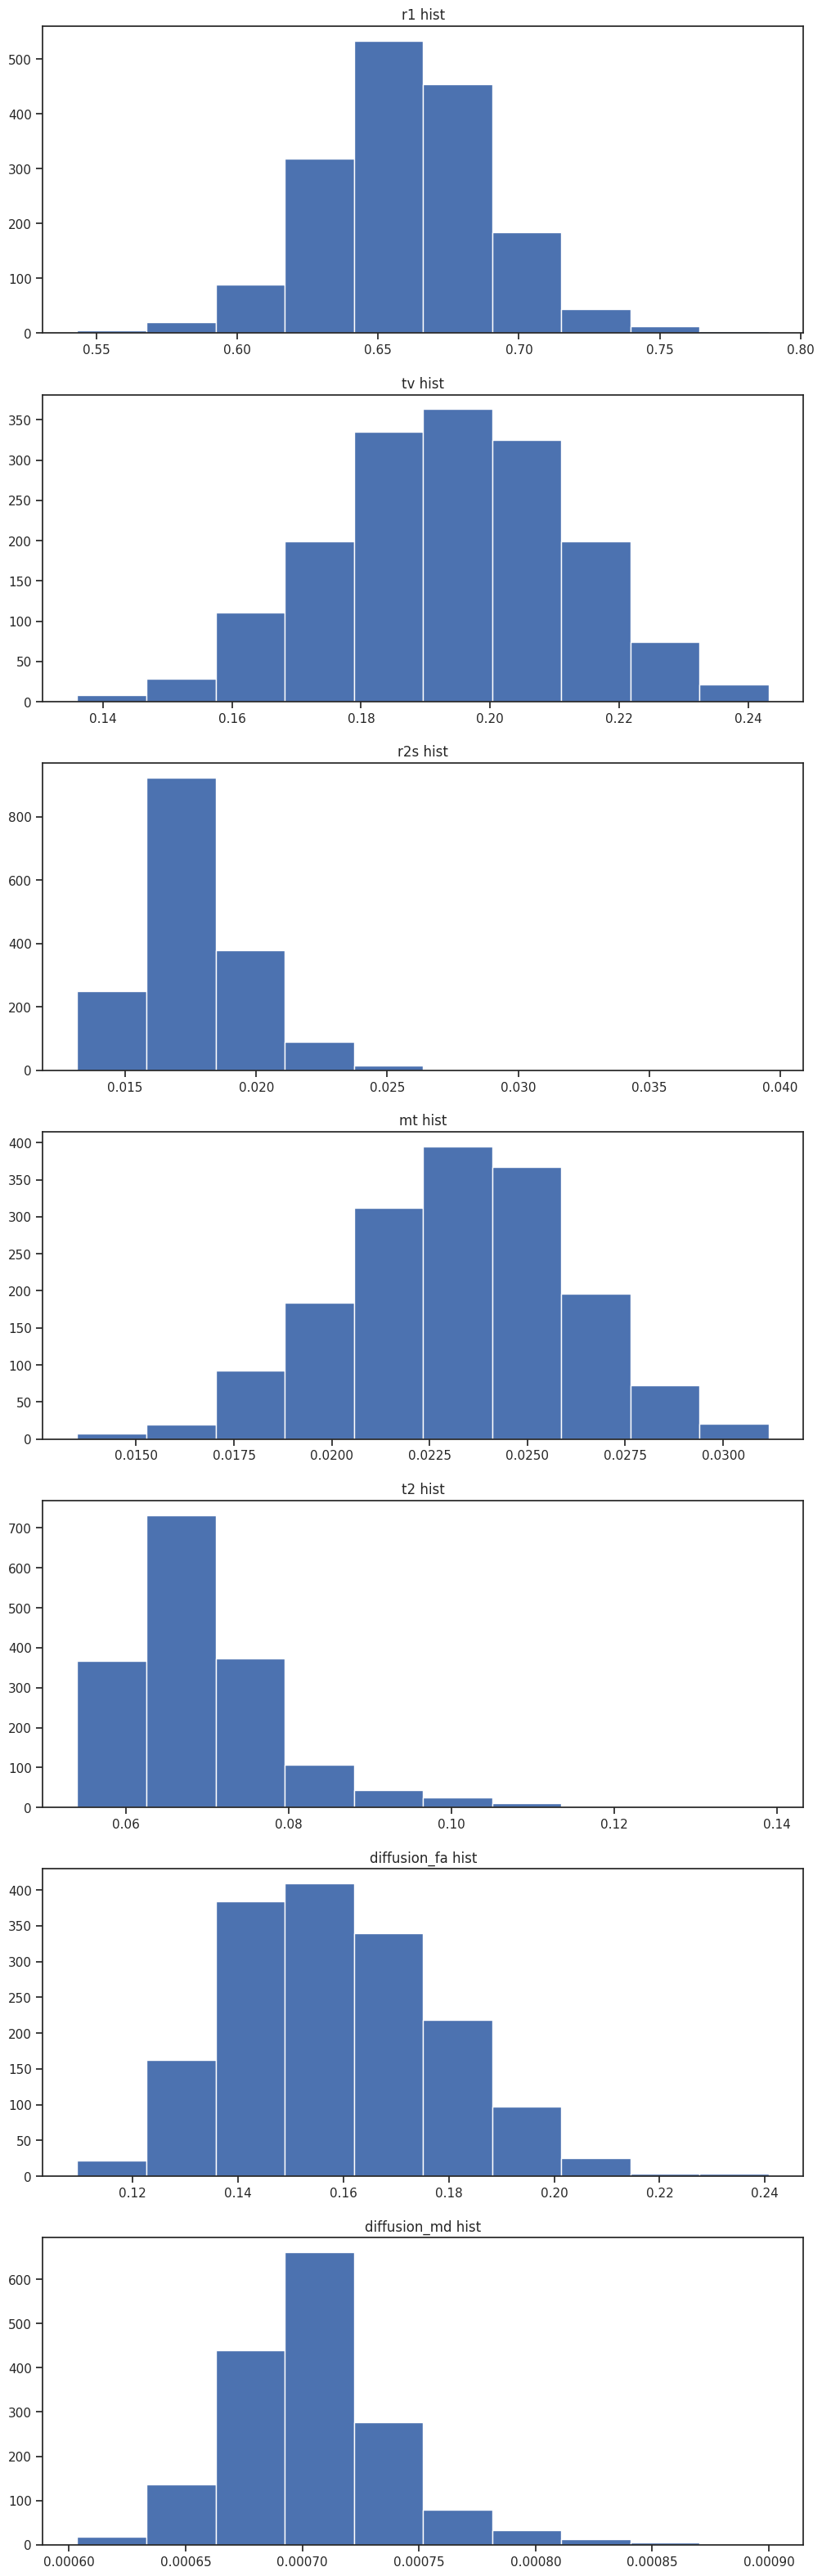

In [7]:
fig, ax = plt.subplots(nrows=7, ncols=1, figsize=(12, 40))

for i, param in  enumerate(params_to_work_with):
    ax[i].set_title(f'{param} hist')
    ax[i].hist(chosen_data_raw[param])

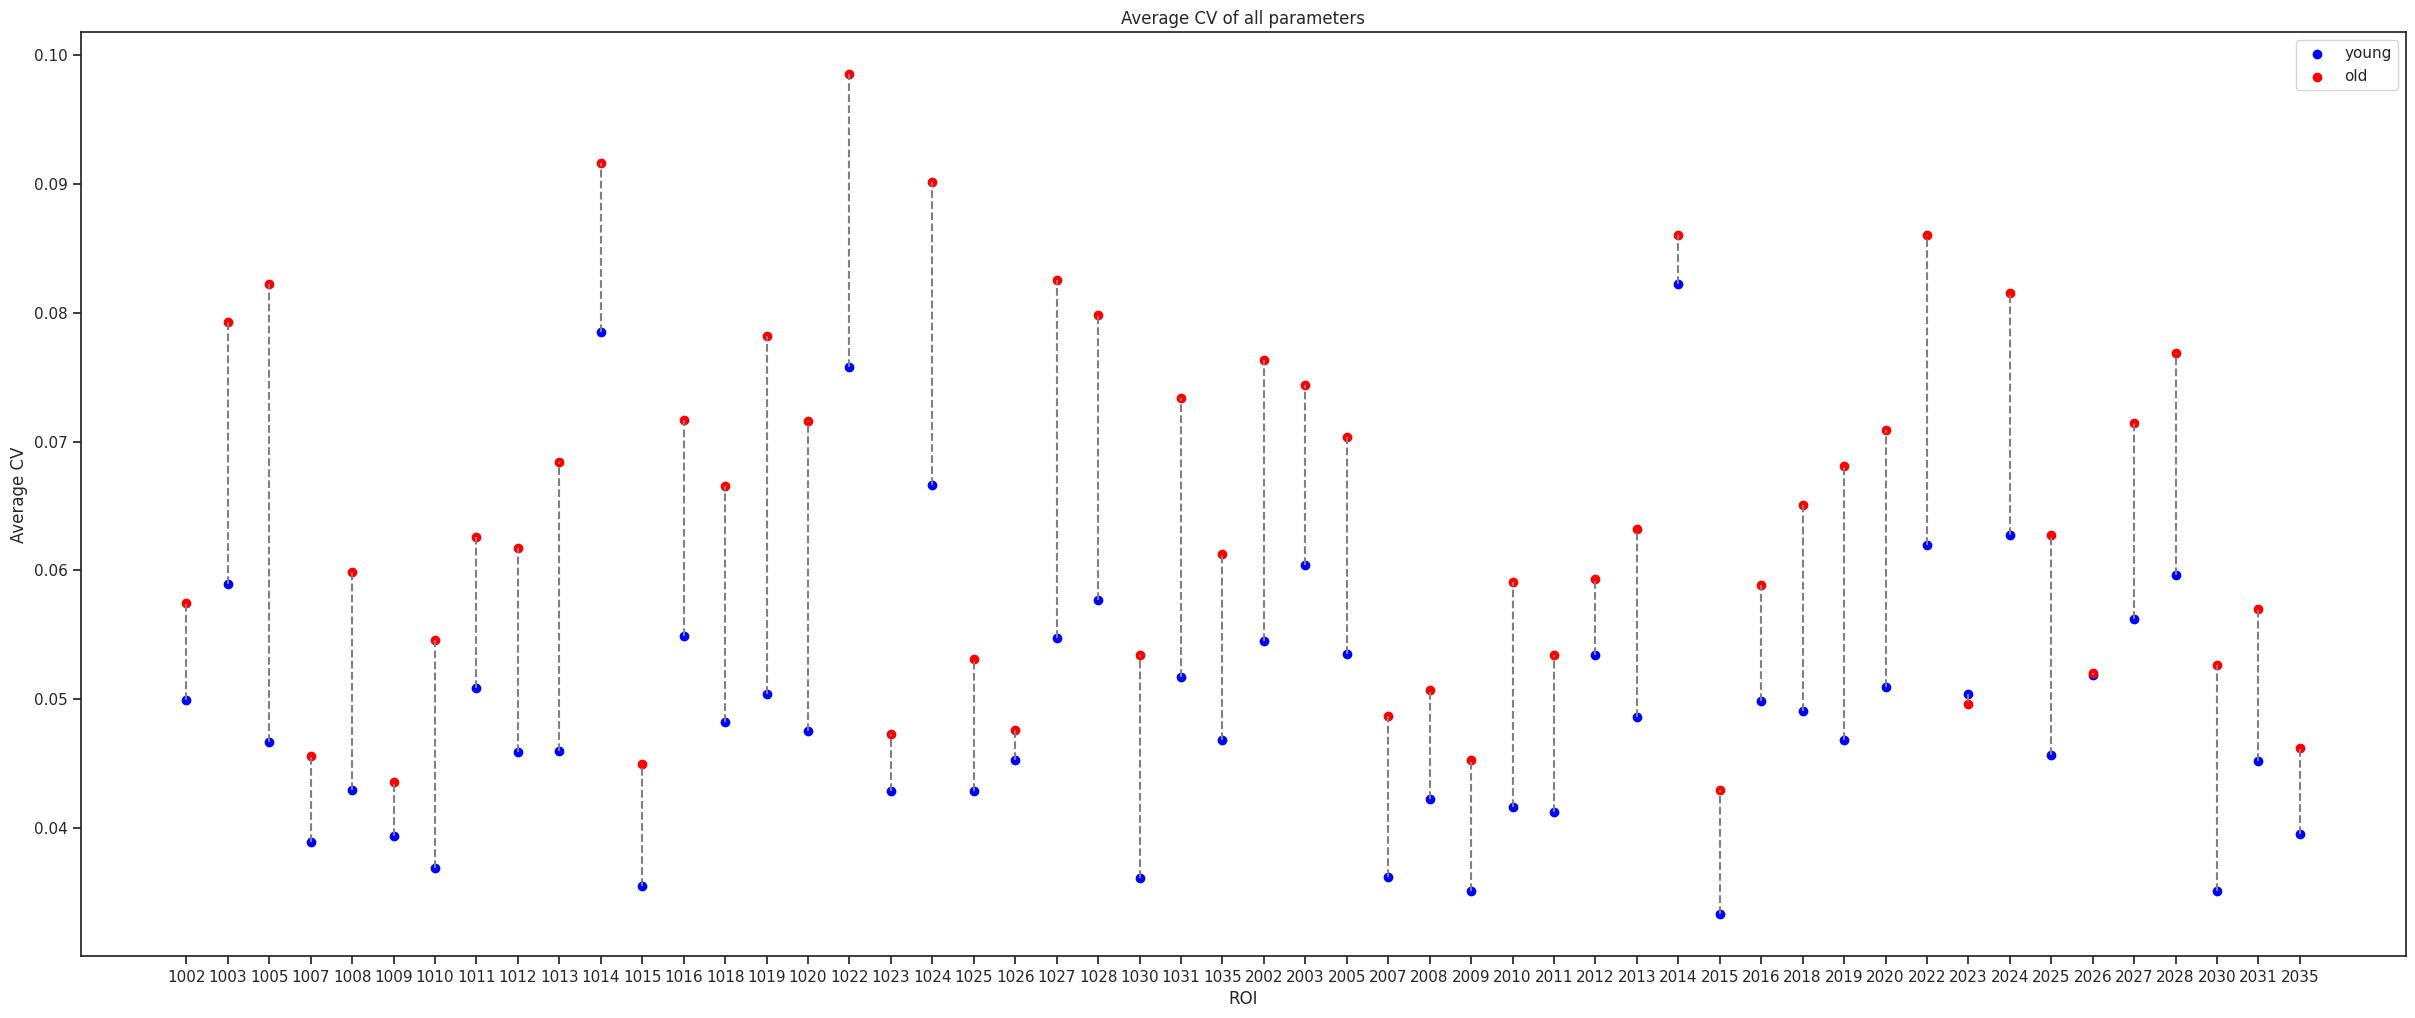

In [6]:
%autoreload 2
data_groups = [(young_subjects_raw, 'blue', 'young'), (old_subjects_raw, 'red', 'old')]
StatisticsWrapper.calculate_cv_for_rois(data_groups, chosen_rois_dict.keys(), params_to_work_with, fig_size=(30, 12))

In [ ]:
group_by_param = 'ROI'
x_axis = 'ROI'
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

In [ ]:
%autoreload 2
StatisticsWrapper.plot_data_per_param_per_roi_next_to_each_other(young_subjects_raw, old_subjects_raw,
                                                                            params_to_work_with,
                                                                            'young', 'old')

In [ ]:
%autoreload 2
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data_raw, 'blue', '')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True, fig_size=(12, 8))

In [38]:
raw_data = DataProcessor(constants.PATH_TO_CORTEX_all_params_raw, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
rois_volume = {}

for roi, roi_data in raw_data.groupby('ROI_name'):
    roi_volumes = 0
    for i, value in roi_data.iterrows():
        roi_volumes += value['r1'].shape[0]

    roi_volumes /= len(roi_data)
    rois_volume[roi] = roi_volumes
    print(f'roi: {roi}, volume: {roi_volumes}')

# plt.figure(figsize=(40, 15))
# plt.scatter(rois_volume.keys(), rois_volume.values())    

roi: ctx-lh-caudalanteriorcingulate, volume: 3206.5833333333335
roi: ctx-lh-caudalmiddlefrontal, volume: 6272.416666666667
roi: ctx-lh-cuneus, volume: 3929.25
roi: ctx-lh-fusiform, volume: 8268.666666666666
roi: ctx-lh-inferiorparietal, volume: 11859.138888888889
roi: ctx-lh-inferiortemporal, volume: 12895.944444444445
roi: ctx-lh-insula, volume: 6167.25
roi: ctx-lh-isthmuscingulate, volume: 2459.75
roi: ctx-lh-lateraloccipital, volume: 13242.777777777777
roi: ctx-lh-lateralorbitofrontal, volume: 8983.944444444445
roi: ctx-lh-lingual, volume: 6350.361111111111
roi: ctx-lh-medialorbitofrontal, volume: 4703.472222222223
roi: ctx-lh-middletemporal, volume: 13911.833333333334
roi: ctx-lh-parahippocampal, volume: 2021.8333333333333
roi: ctx-lh-parsopercularis, volume: 4096.388888888889
roi: ctx-lh-parsorbitalis, volume: 2266.1944444444443
roi: ctx-lh-parstriangularis, volume: 4816.416666666667
roi: ctx-lh-postcentral, volume: 9936.333333333334
roi: ctx-lh-posteriorcingulate, volume: 3173.86

F test to check if the age is significant to the cv

In [18]:
%autoreload 2
group_by_param = 'subjects'
x_axis = 'Age'
StatisticsWrapper.calculate_cv_f_test(chosen_data_raw, group_by_param, params_to_work_with, x_axis)

Param r1 - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param tv - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param r2s - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param mt - Reject the null hypothesis: complex_model is significantly better than simple_model
Param t2 - Reject the null hypothesis: complex_model is significantly better than simple_model
Param diffusion_fa - Fail to reject the null hypothesis: No significant difference between simple_model and complex_model
Param diffusion_md - Reject the null hypothesis: complex_model is significantly better than simple_model


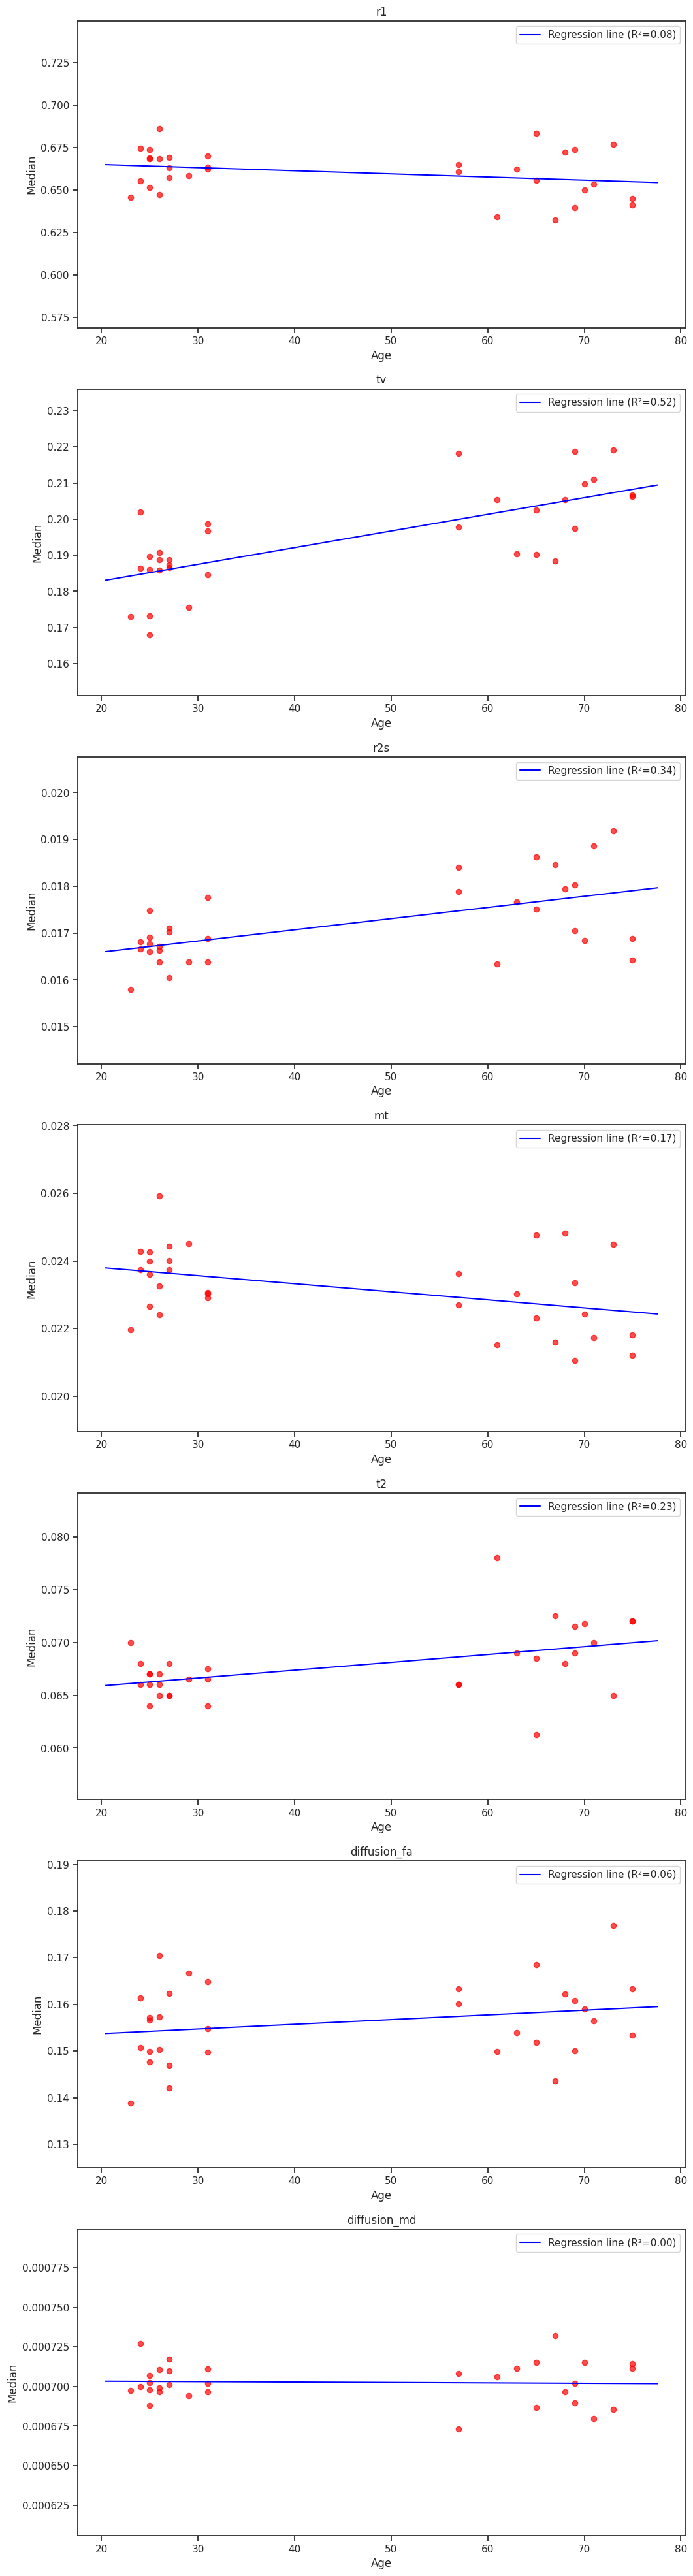

In [19]:
fig, ax = plt.subplots(nrows=len(params_to_work_with), ncols=1, figsize=(12, 50))

for i, param in  enumerate(params_to_work_with):
    medians = chosen_data_raw.groupby('subjects')[[param, 'Age']].median()
    ax[i].scatter(medians['Age'], medians[param], color='red', s=35, alpha=0.7)
    ax[i].set_title(f'{param}')
    ax[i].set_xlabel('Age')
    ax[i].set_ylabel('Median')
    lim = 0.1
    ax[i].set_ylim([min(medians[param]) - lim*min(medians[param]), max(medians[param]) + lim*min(medians[param])])


    # Calculate linear regression
    slope, intercept, r_value, p_value, std_err = linregress(medians['Age'], medians[param])
    x_values = np.array(ax[i].get_xlim())
    y_values = intercept + slope * x_values
    ax[i].plot(x_values, y_values, color='blue', label=f'Regression line (R²={r_value**2:.2f})')
    ax[i].legend()


In [70]:
%autoreload 2
rois = [('ctx-rh-rostralmiddlefrontal', 'ctx-rh-insula'), ('ctx-rh-rostralmiddlefrontal', 'ctx-rh-inferiortemporal'),
         ('ctx-rh-insula', 'ctx-rh-inferiortemporal'), ('ctx-rh-caudalmiddlefrontal', 'ctx-lh-isthmuscingulate'), ('ctx-rh-parstriangularis', 'ctx-rh-caudalanteriorcingulate')]
for roi_pair in rois:
    StatisticsWrapper.show_rois_differences_in_polar(young_subjects_z_score, old_subjects_z_score, roi_pair[0], roi_pair[1], params_to_work_with, ('young', 'old'))


## Check correlations on the normalized data

In [47]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of old group', method=method)
                        
    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)
    young_corr_means, old_corr_means  = show_corr_mean(young_result, old_result, clusters_rois, 'Average correlations')

    # PlotsManager.plot_colors_on_brain(young_data.subjects.iloc[0], young_corr_means, chosen_rois_dict, 'young_corr', 'heat')
    # PlotsManager.plot_colors_on_brain(young_data.subjects.iloc[0], old_corr_means, chosen_rois_dict, 'old_corr', 'heat')

def show_corr_mean(young_result, old_result, clusters_rois, title):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
    
    ax.set_xticks(clusters_rois)
    ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=8)

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    # ax.set_facecolor('white')
    ax.grid(True)
    ax.legend()

    return young_result['corr_mean'], old_result['corr_mean']

def show_distances(method, params_to_work_with, all_data, young_subjects, old_subjects, title):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single'
                                                       ,title="all")['dendrogram_data']['ivl']
    young_distances = StatisticsWrapper.roi_distances(young_subjects, params_to_work_with, clusters_rois, method=method, title=f'Young rois {title}')
    old_distances = StatisticsWrapper.roi_distances(old_subjects, params_to_work_with, clusters_rois, method=method, title=f'Old rois {title}')

    _, __ = show_corr_mean(young_distances, old_distances, clusters_rois, f'Average ROIS {title}')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:544: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



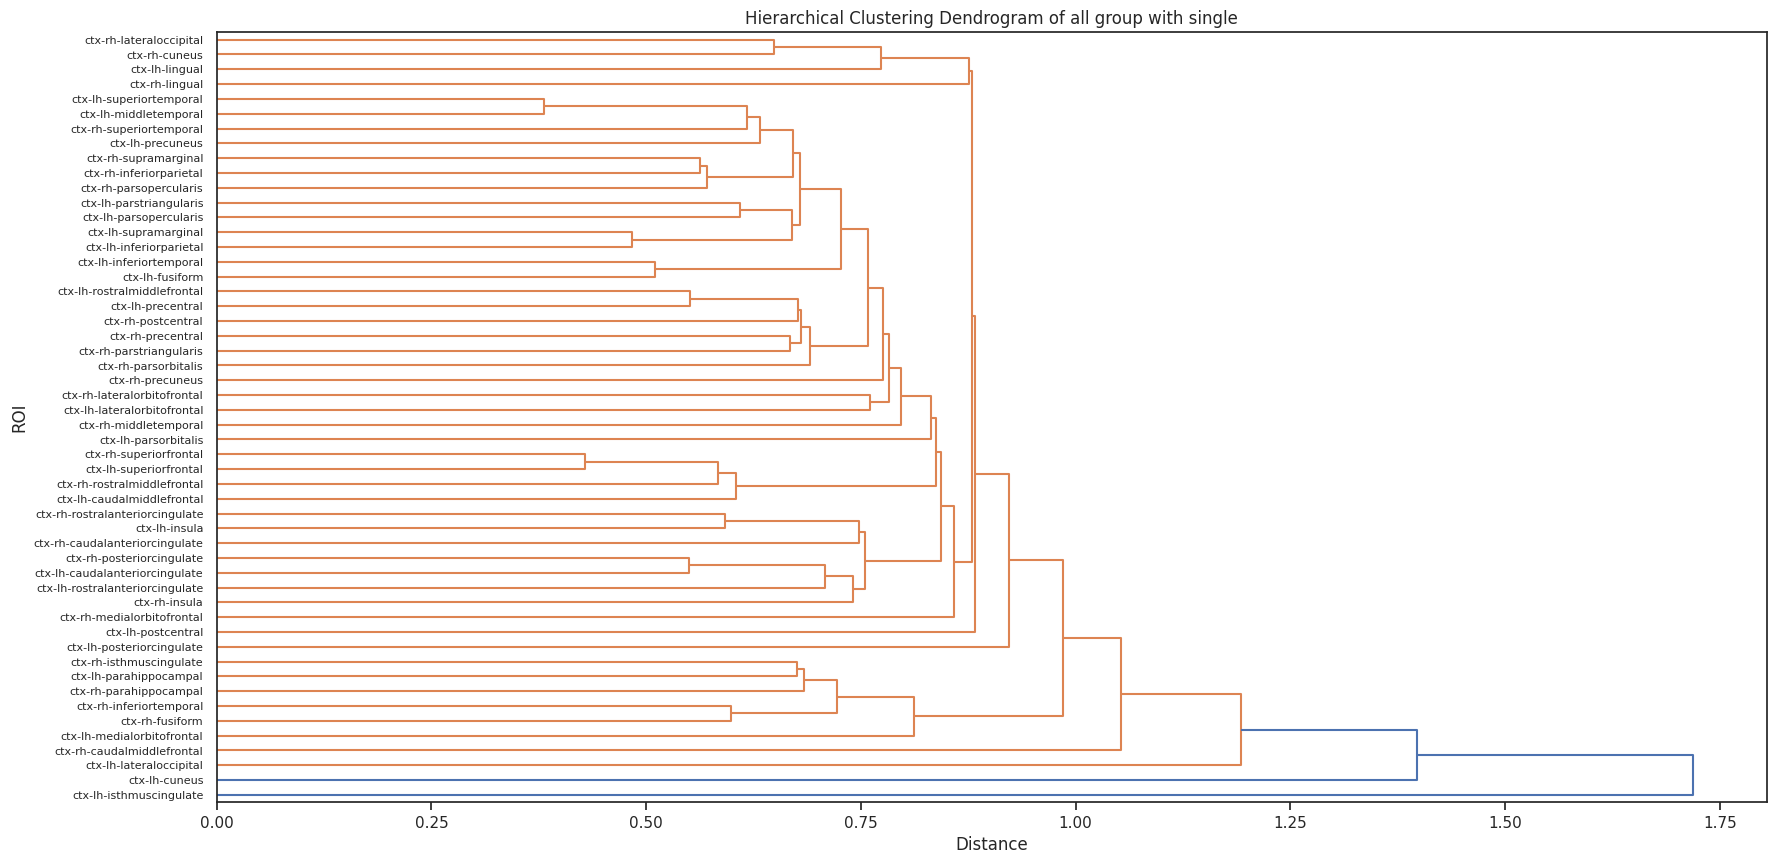

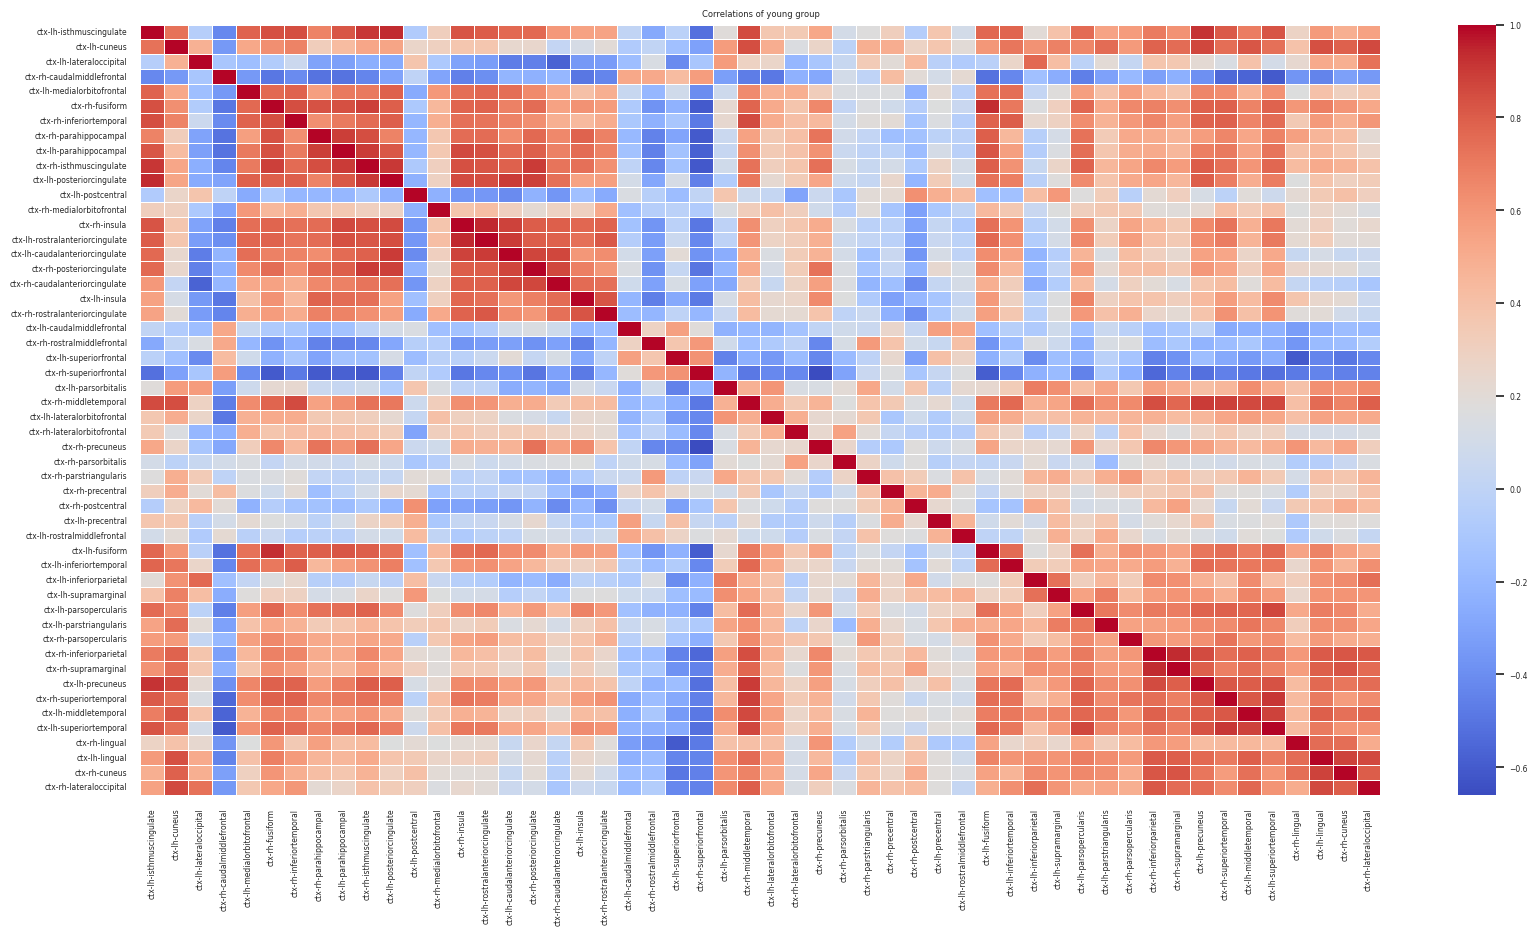

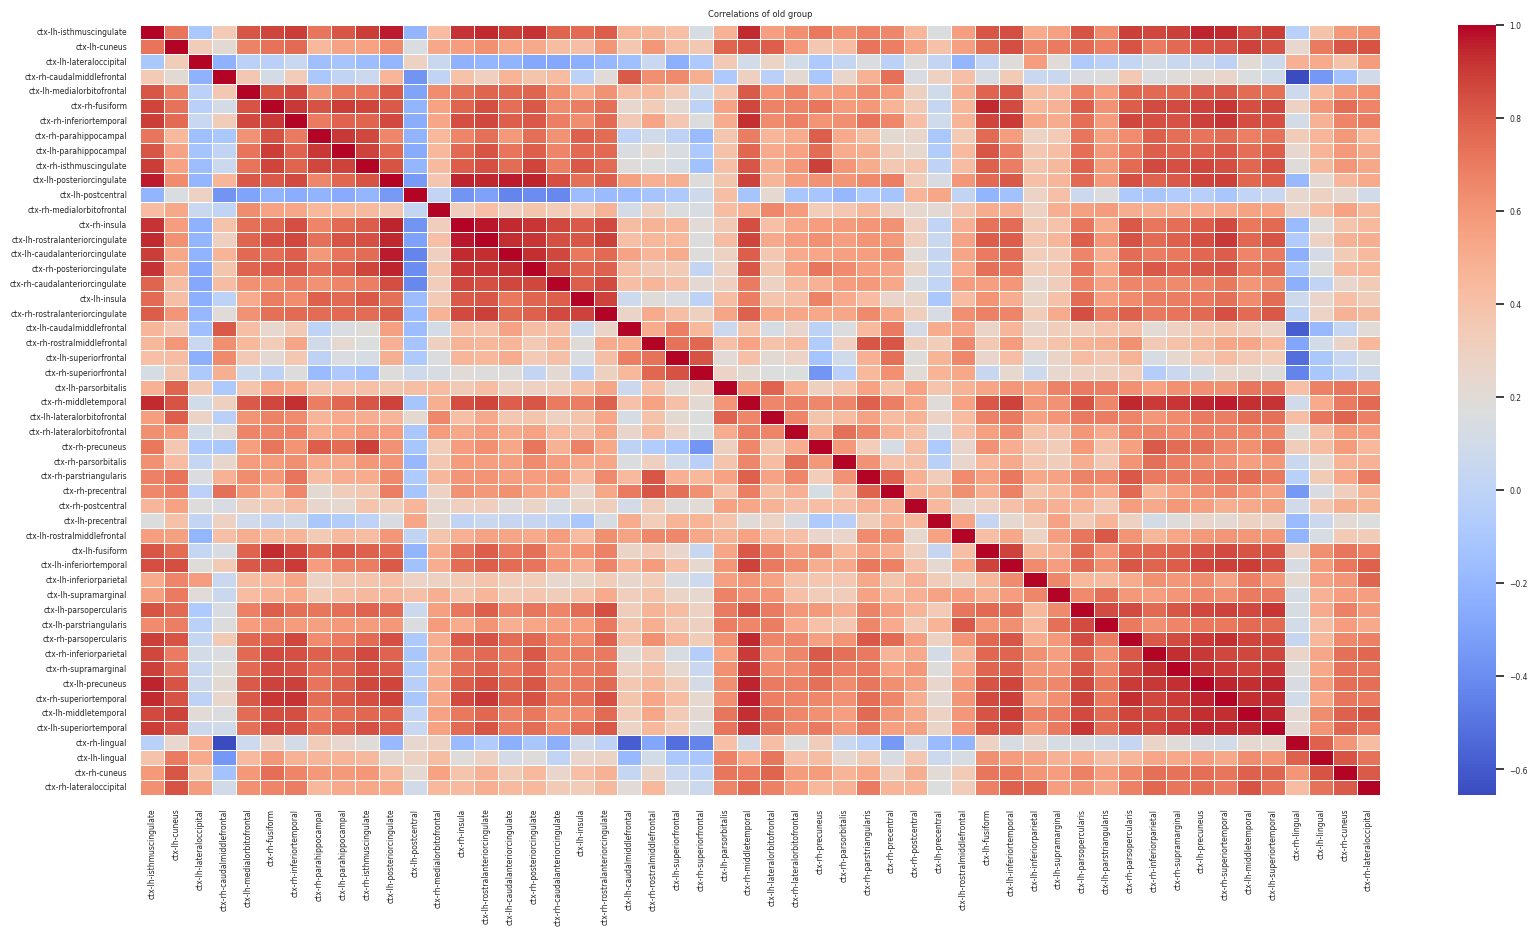

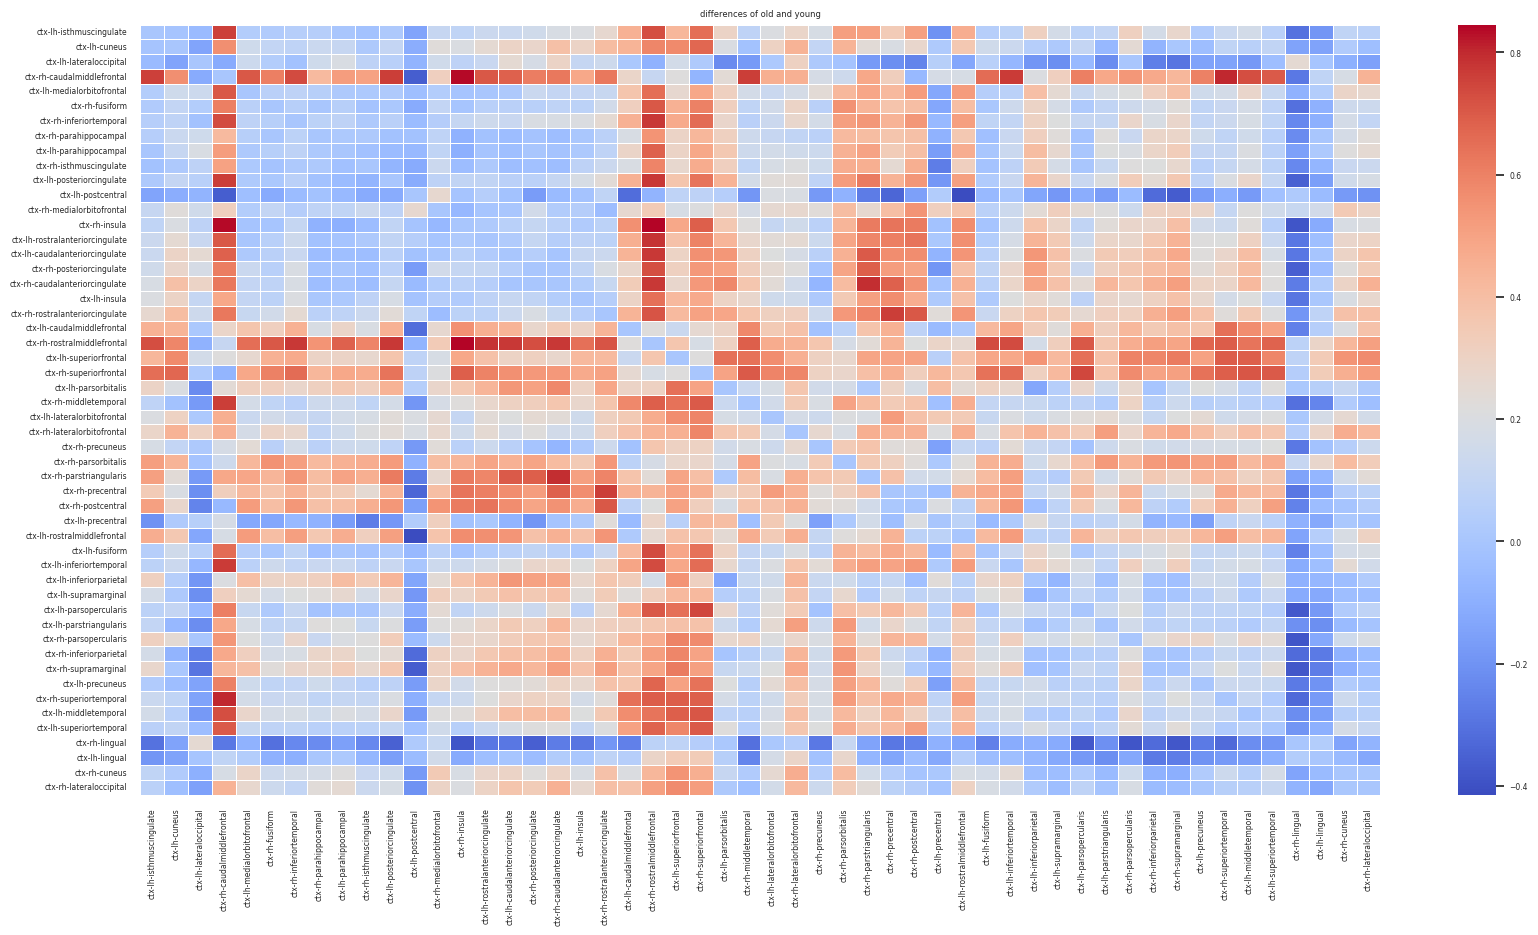

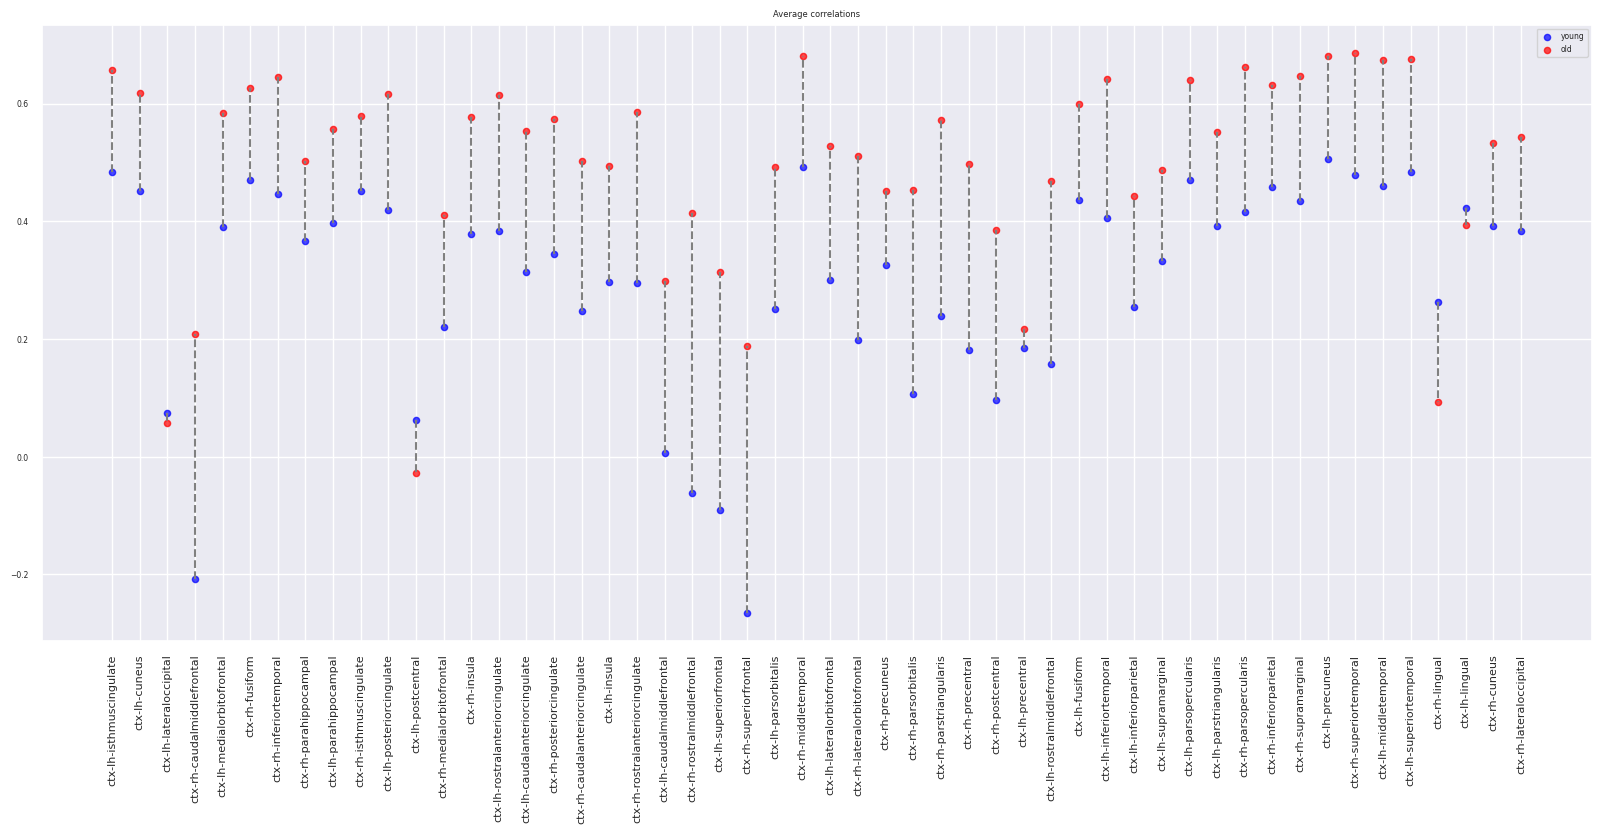

In [46]:
%autoreload 2
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


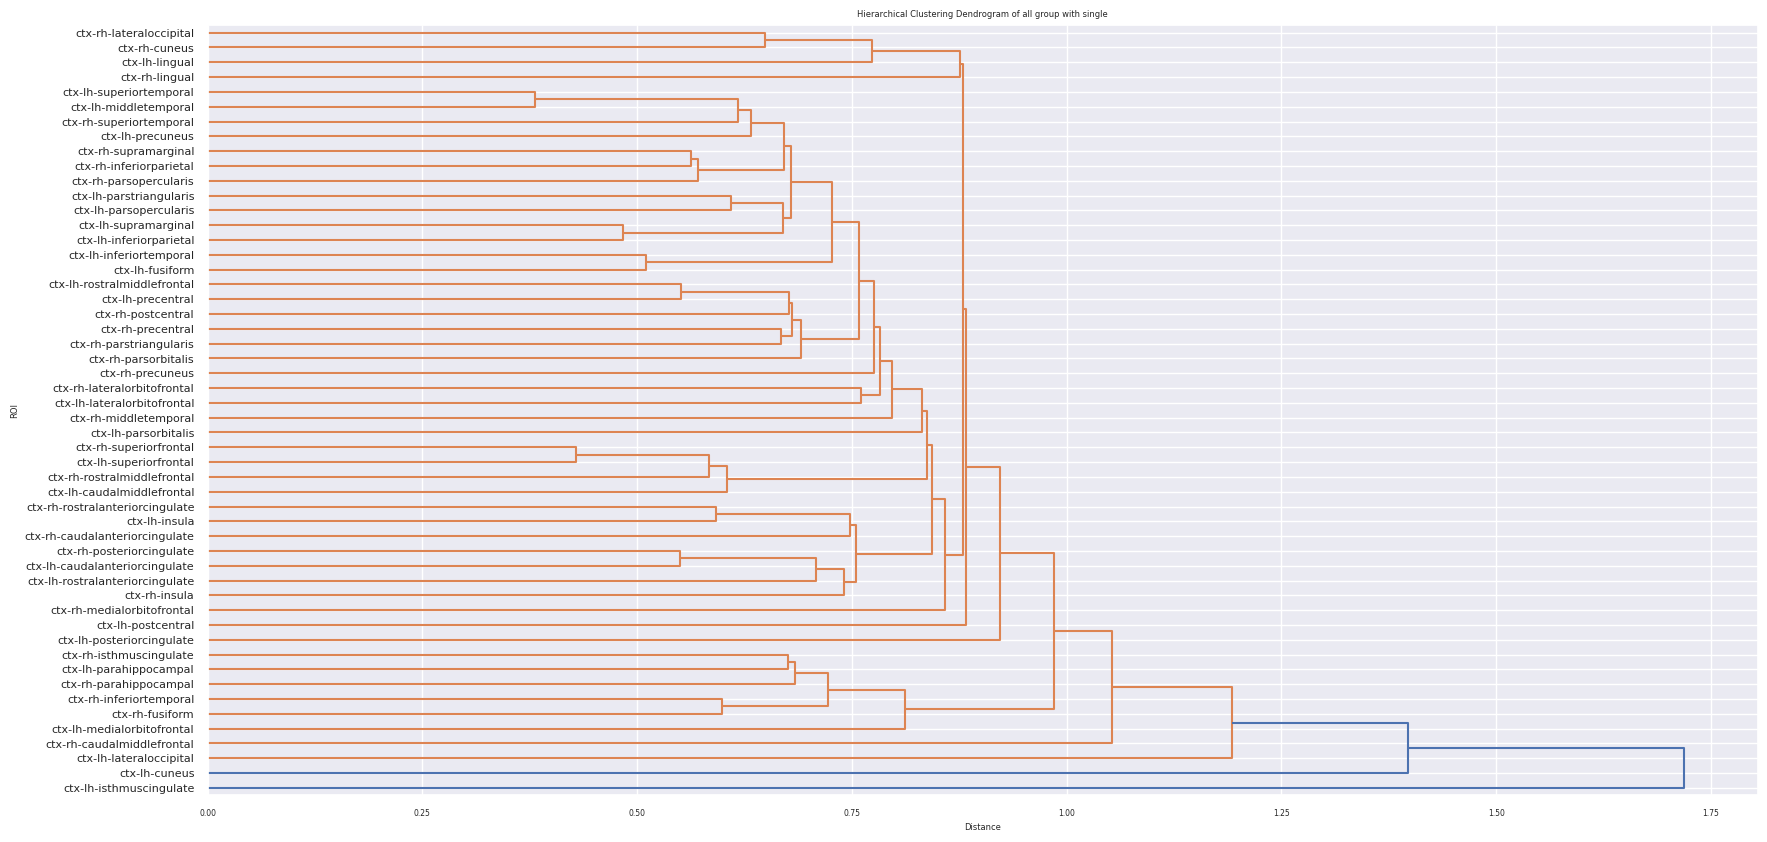

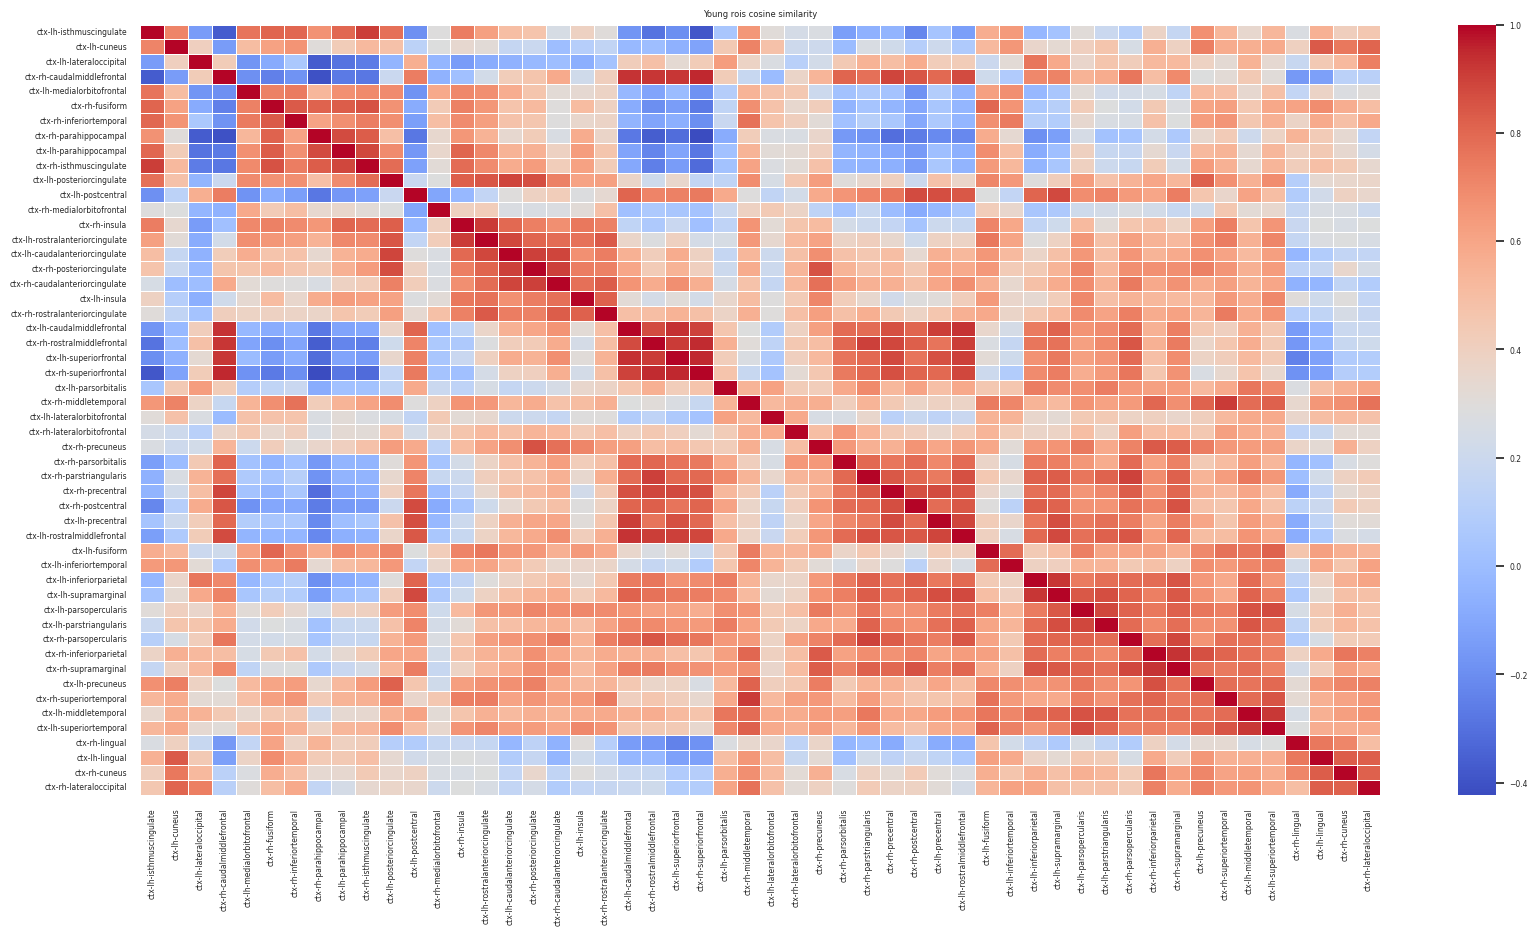

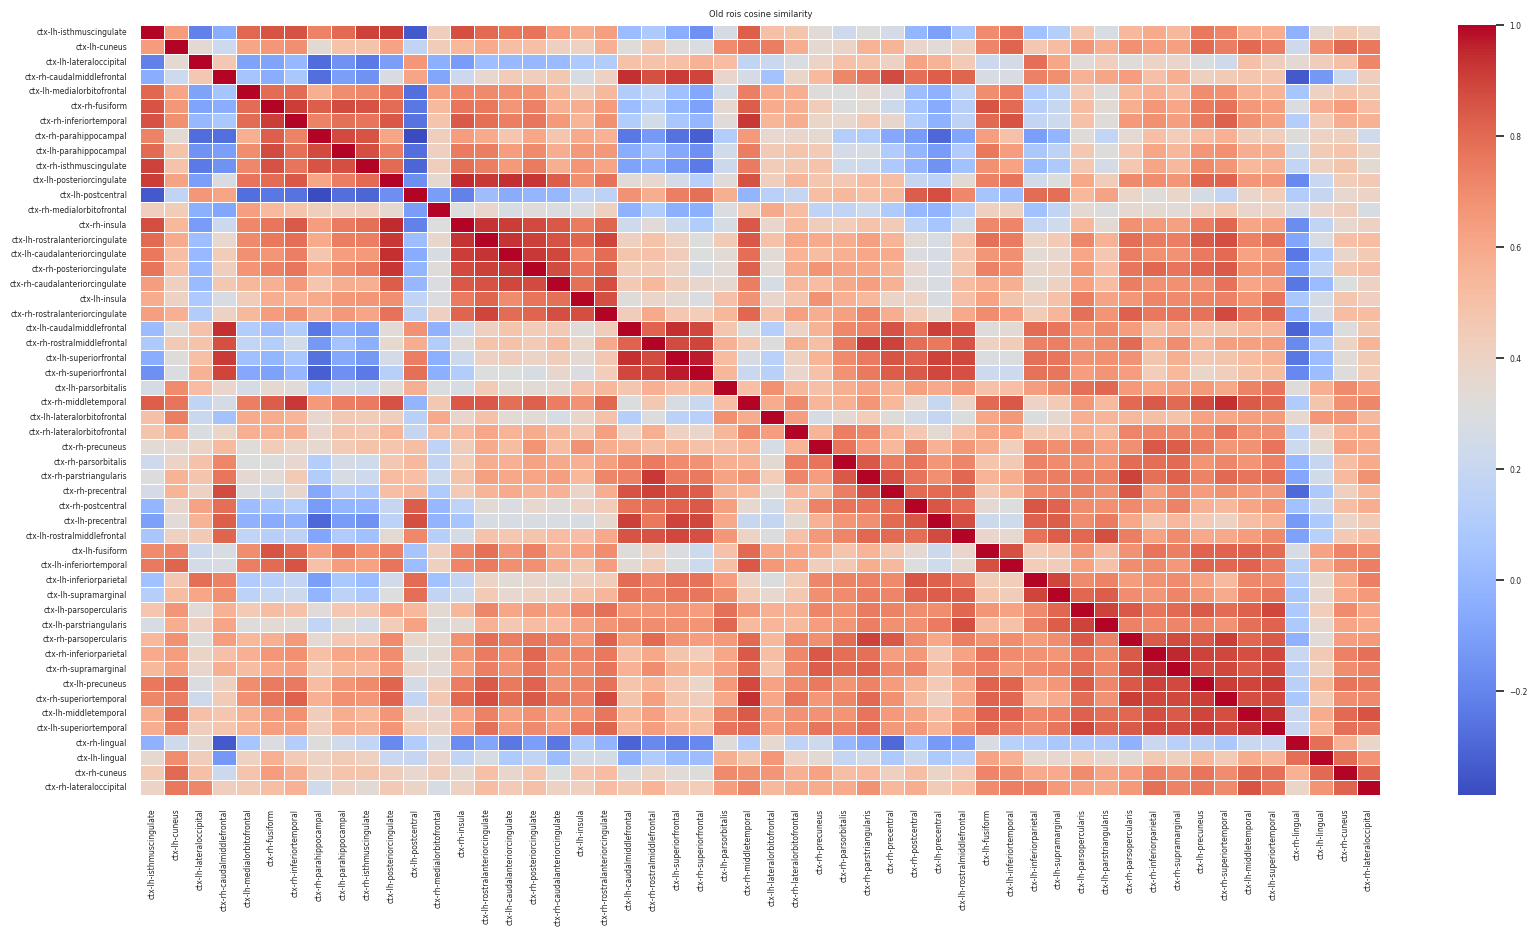

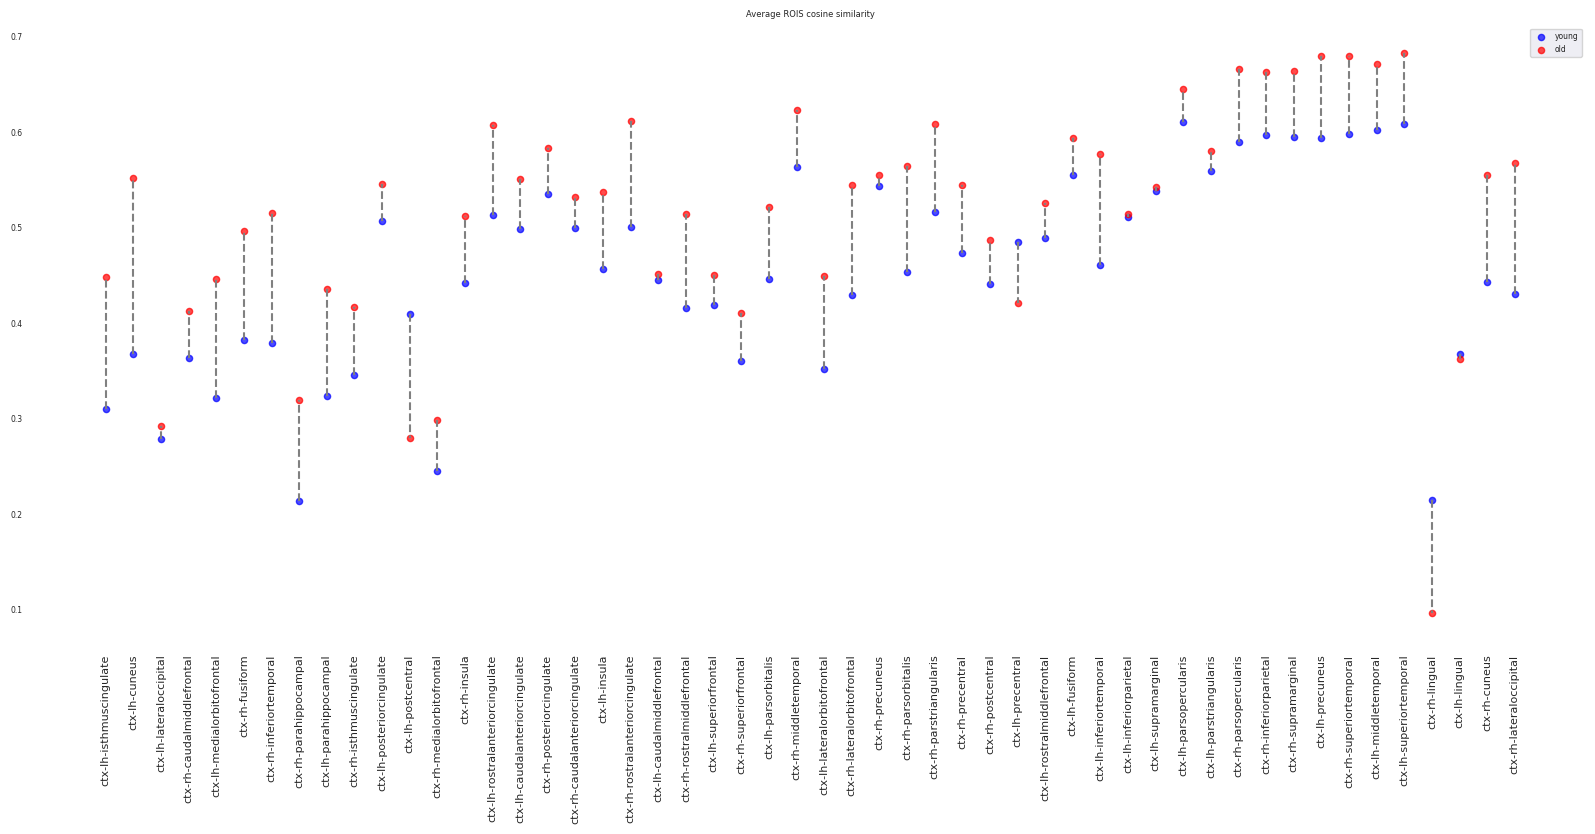

In [10]:
show_distances(cosine_similarity, params_to_work_with, chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'cosine similarity')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:534: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


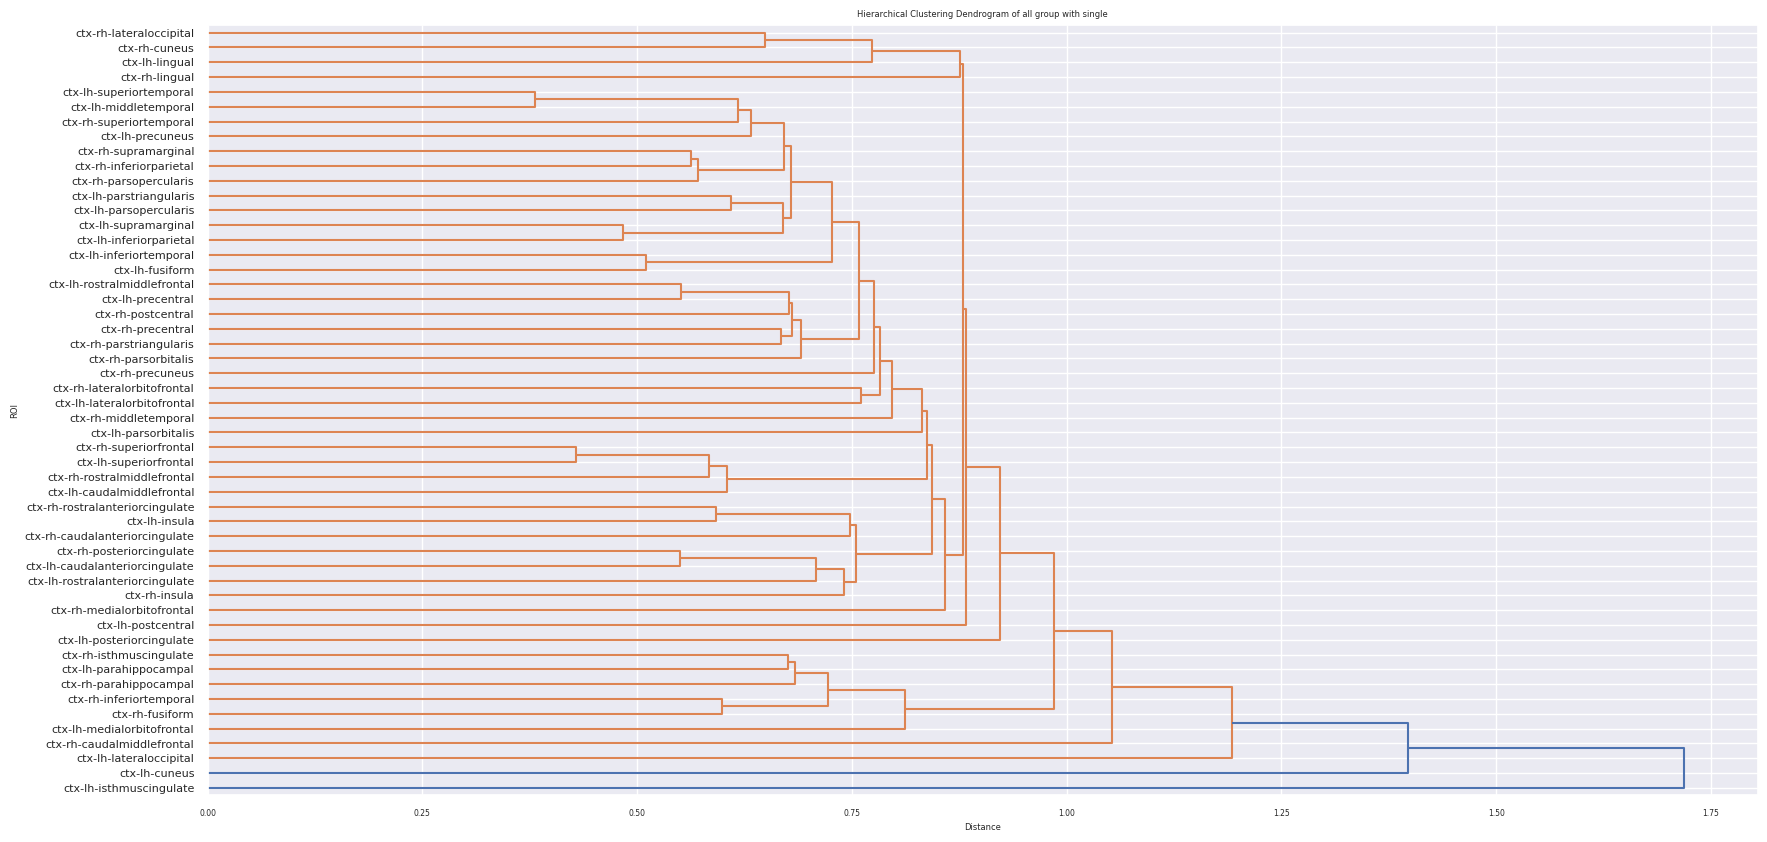

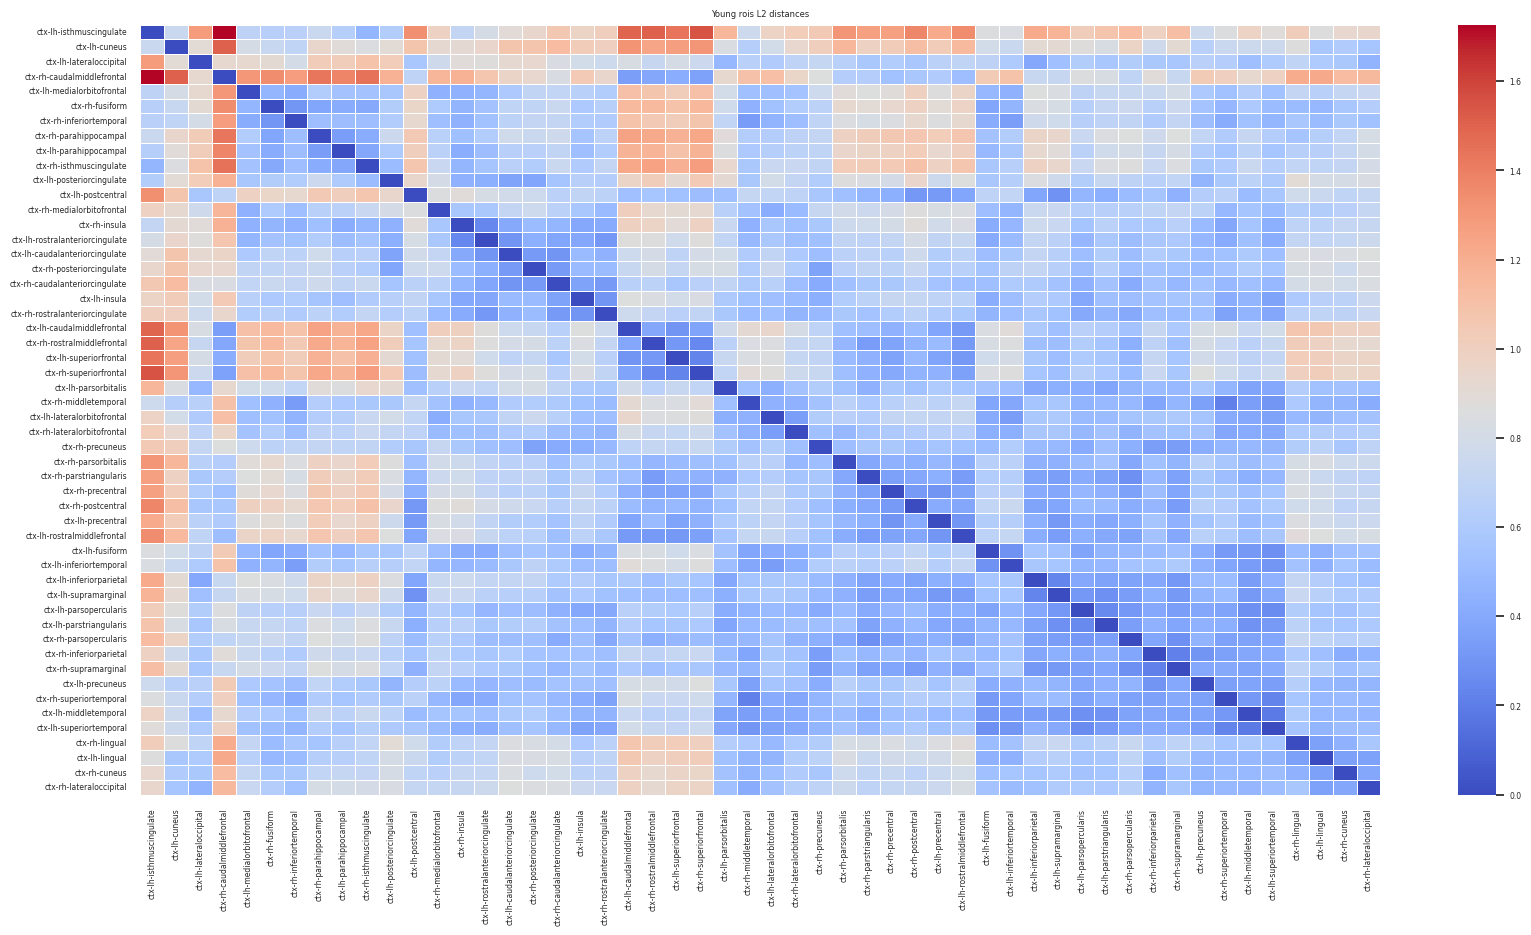

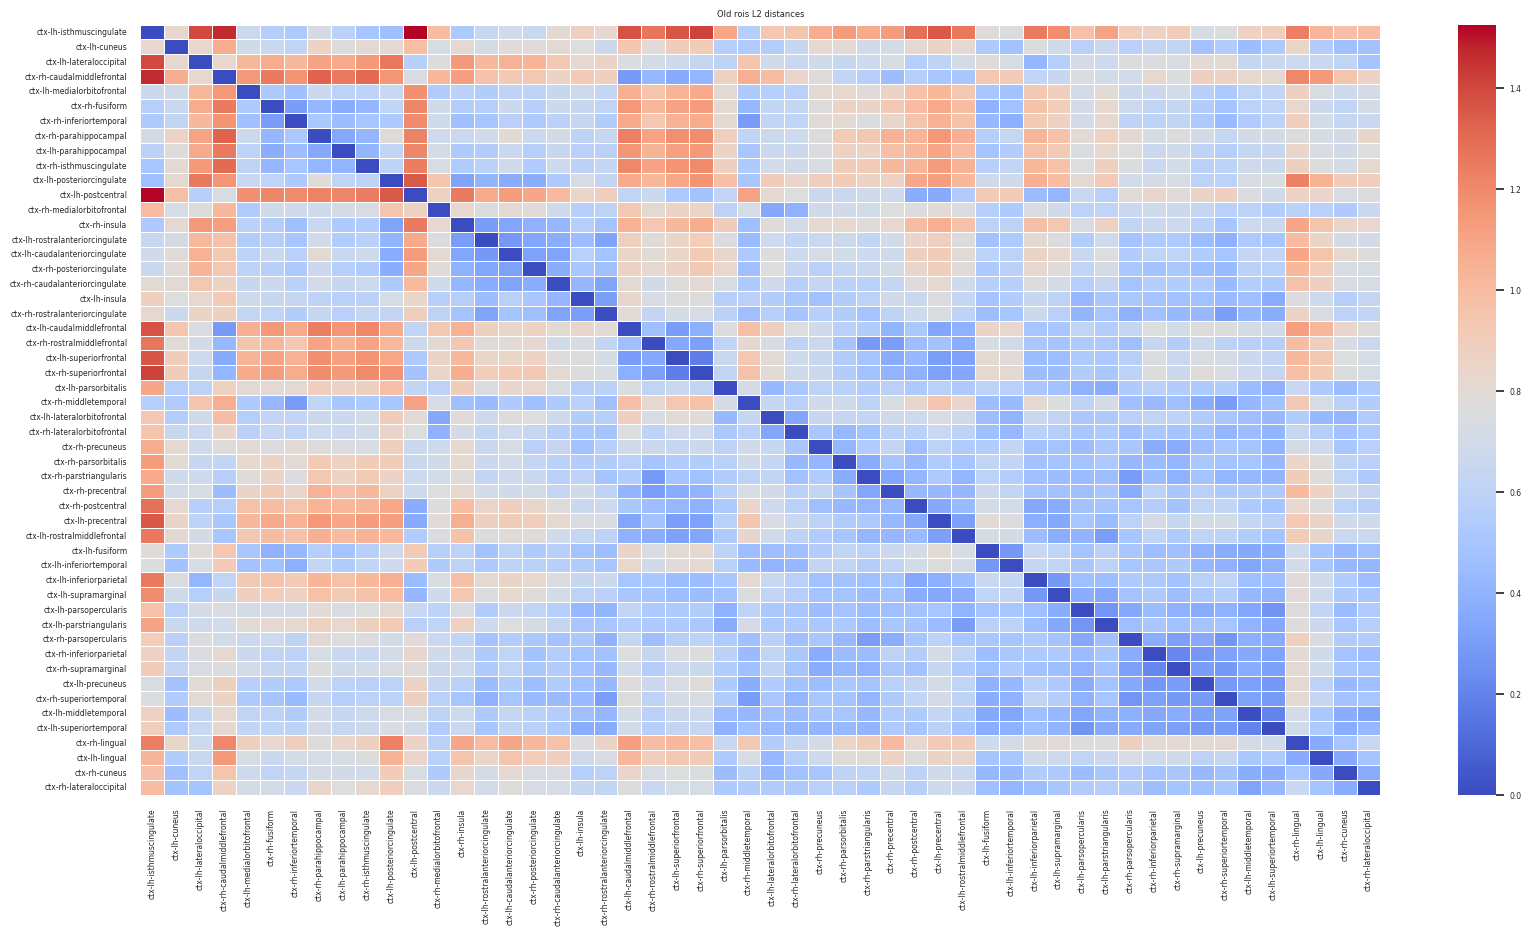

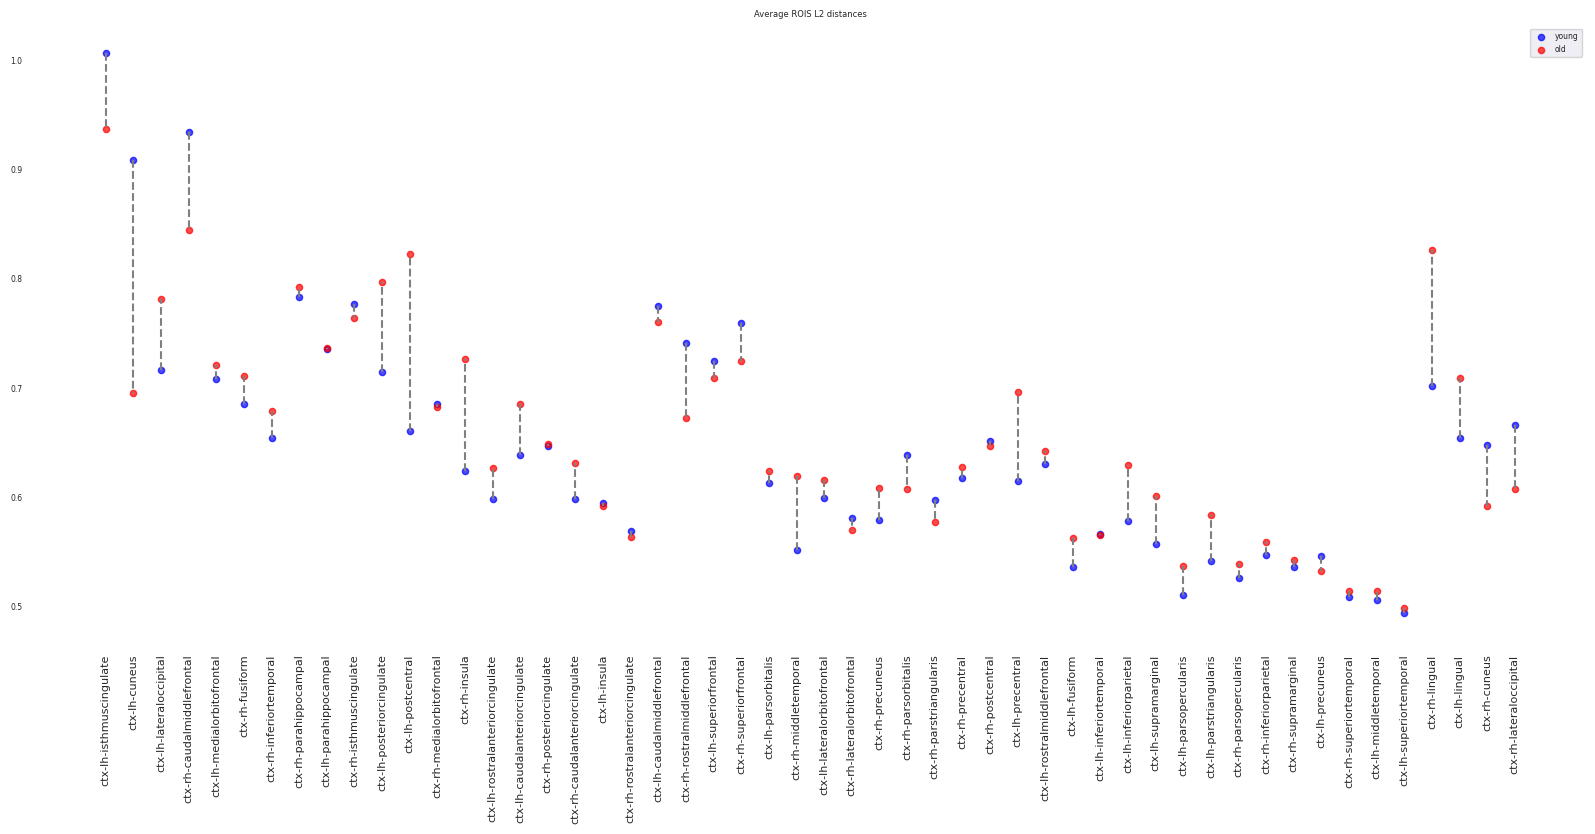

In [11]:
show_distances(distance_matrix, params_to_work_with, chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'L2 distances')

In [ ]:
%autoreload 2
StatisticsWrapper.roi_distances_by_age(chosen_data_z_score, params_to_work_with)

Check t_test on the young and old groups

param r1 number of areas with significance differences: 37
param tv number of areas with significance differences: 15
param r2s number of areas with significance differences: 17
param mt number of areas with significance differences: 23
param t2 number of areas with significance differences: 30
param diffusion_fa number of areas with significance differences: 21
param diffusion_md number of areas with significance differences: 30


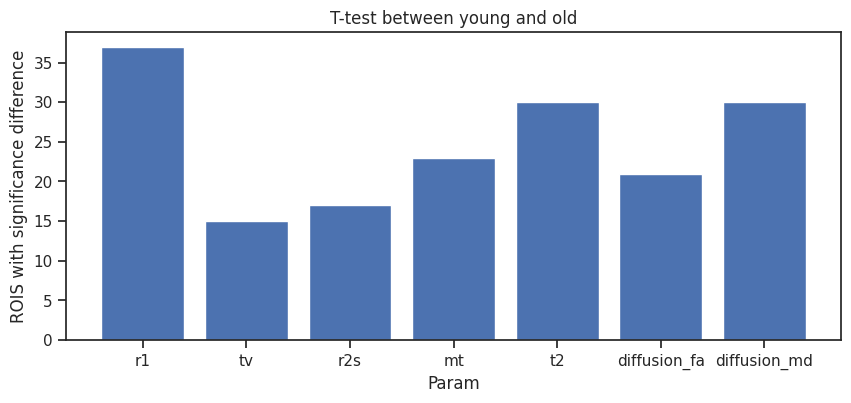

In [7]:
%autoreload 2
StatisticsWrapper.t_test_per_parameter_per_area(young_subjects_z_score, old_subjects_z_score, chosen_rois_dict, 'ROI', params_to_work_with)

Subjects clustering 

In [16]:
def reduce_dim(model, data, drop_label=True):
    if drop_label:
        res = model.fit_transform(data.drop(columns='label'))
    else:
        res = model.fit(data.drop(columns='label'), data['label']).transform(data.drop(columns='label'))  

    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    reduced_data['label'] = data['label']
    # print(f'kl divergence: {model.kl_divergence_}')
    return reduced_data

In [17]:
young_features_df = pd.pivot_table(young_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(old_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

young_mask = young_features_df.index
old_mask = old_features_df.index

# Assign labels directly to data_reduced_tsne DataFrame
data_features_df.loc[young_mask, 'label'] = 'young'
data_features_df.loc[old_mask, 'label'] = 'old'

In [19]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=36)

data_reduced_pca = reduce_dim(pca, data_features_df, drop_label=True)
# data_reduced_tsne = reduce_dim(tsne, data_features_df, drop_label=True)

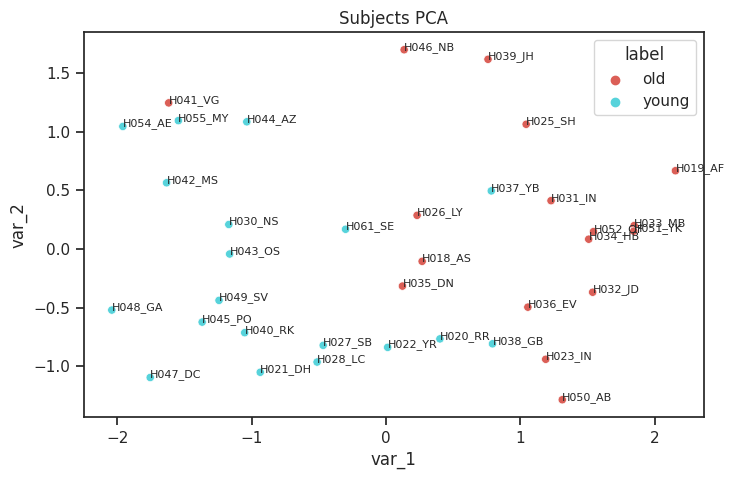

In [20]:
fig, ax = plt.subplots(figsize=(8,5))

sns.scatterplot(
    x="var_1", y="var_2",
    hue='label',
    palette=sns.color_palette("hls", 2),
    data=data_reduced_pca,
    legend="full",
    ax=ax
    ).set_title('Subjects PCA')

for i, txt in enumerate(data_reduced_pca.index):
    ax.annotate(txt, (data_reduced_pca['var_1'][i], data_reduced_pca['var_2'][i]), fontsize=8)


In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=config.seed)
        data_reduced_tsne = reduce_dim(tsne, data_features_df)

        young_df_tsne = data_reduced_tsne.loc[young_features_df.index]
        old_df_tsne = data_reduced_tsne.loc[old_features_df.index]

        fig, ax = plt.subplots(figsize=(10,8))
        ax.scatter(young_df_tsne['var_1'], young_df_tsne['var_2'], color='blue', label='young')
        ax.scatter(old_df_tsne['var_1'], old_df_tsne['var_2'], color='red', label='old')

        for i, txt in enumerate(young_df_tsne.index):
            ax.annotate(txt, (young_df_tsne['var_1'][i], young_df_tsne['var_2'][i]), fontsize=8)

        for i, txt in enumerate(old_df_tsne.index):
            ax.annotate(txt, (old_df_tsne['var_1'][i], old_df_tsne['var_2'][i]), fontsize=8) 

        plt.legend()
        plt.title(f'Subjects t-SNE perplexity {config.perplexity}')
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": list(range(2, 5))},
        "seed": {"values": [0, 42, 36]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize_no_outliers")
wandb.agent(sweep_id, function=tsne_cluster)

Rois clustering

In [61]:
all_features_df = chosen_data_z_score[params_to_work_with]

young_mask = young_subjects_z_score.index
old_mask = old_subjects_z_score.index

# Assign labels directly to DataFrame
all_features_df.loc[young_mask, 'label'] = 'young'
all_features_df.loc[old_mask, 'label'] = 'old'

/tmp/ipykernel_1226938/490072393.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_features_df.loc[young_mask, 'label'] = 'young'


In [68]:
model = TSNE(n_components=2, perplexity=50, random_state=0)
# model = PCA(n_components=2)
all_df_reduced = reduce_dim(model, all_features_df)

In [69]:
def plot_clusters_of_rois(reduced_data, prev_data, title):

    hue = []

    for roi in prev_data['ROI_name']:
        for lobe, lobe_values in constants.LOBES.items():
            if roi in lobe_values:
                hue.append(lobe)

    sns.scatterplot(
        x="var_1", y="var_2",
        hue=hue,
        palette=sns.color_palette("husl", len(constants.LOBES.keys())),
        data=reduced_data,
        legend="full",
        ).set_title(title)

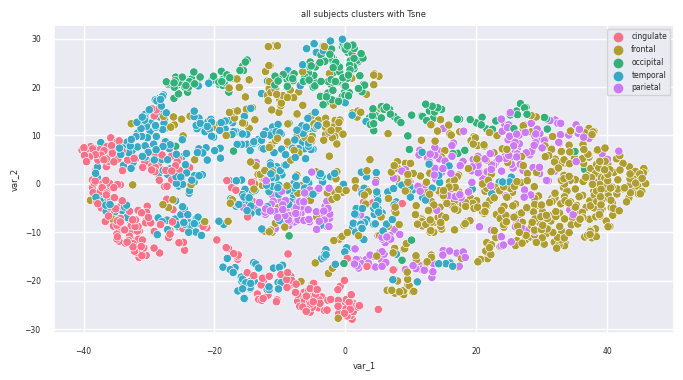

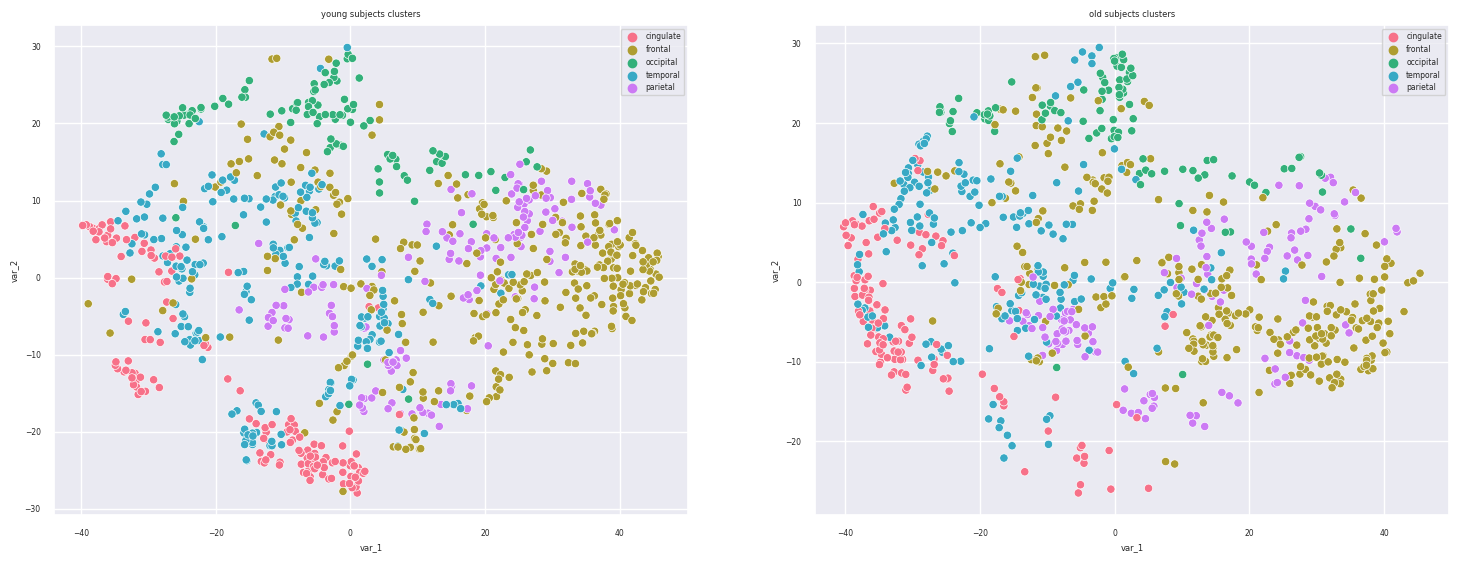

In [70]:
plt.figure(figsize=(8, 4))
plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title="all subjects clusters with Tsne")
plt.figure(figsize=(18, 14))
plt.subplot(2, 2, 1)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'young'], young_subjects_z_score, title="young subjects clusters")
plt.subplot(2, 2, 2)
plot_clusters_of_rois(all_df_reduced[all_df_reduced.label == 'old'], old_subjects_z_score, title="old subjects clusters")

In [71]:
all_df_reduced.groupby('label').describe()

var_1                                                                  
       count      mean        std       min        25%       50%        75%   
label                                                                         
old    832.0 -1.551179  22.773279 -40.22657 -18.719316 -4.007200  15.849687  \
young  936.0  3.070918  21.873747 -39.76263 -12.312062  0.358037  21.606787   

                  var_2                                                       
             max  count      mean        std        min       25%       50%   
label                                                                         
old    45.321976  832.0  1.878253  11.606162 -26.515198 -6.886574 -0.068401  \
young  45.866543  936.0 -0.232459  12.946573 -27.960272 -8.503884  0.749618   

                             
             75%        max  
label                        
old    10.571530  29.491837  
young   8.603784  29.859432

In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=42)
        all_df_reduced = reduce_dim(tsne, all_features_df)

        plot_clusters_of_rois(all_df_reduced, chosen_data_z_score, title=f"subjects clusters with perplexity {config.perplexity}")
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
        # "seed": {"values": [0, 42, 36]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize_rois_clustering")
wandb.agent(sweep_id, function=tsne_cluster)